In [403]:
import json
import os
from typing import List, Dict, Any

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [404]:
# Define the list of years to analyze
years_to_analyze: List[int] = [2023, 2022, 2021, 2020, 2019, 2018, 2017,
                               2016, 2015, 2014]

In [405]:
def load_solar_data(file_path: os.path) -> pd.DataFrame:
    """Load solar data from JSON file and filter relevant fields."""
    if not os.path.isfile(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")

    with open(file_path, 'r') as f:
        solar_data = json.load(f)

    filtered_data: List[Dict[str, Any]] = []
    for item in solar_data:
        filtered_data.append({
            'time-tag': item['time-tag'],
            'ssn': item['ssn'],
            'smoothed_ssn': item['smoothed_ssn'],
            'observed_swpc_ssn': item['observed_swpc_ssn'],
            'smoothed_swpc_ssn': item['smoothed_swpc_ssn'],
            'f10.7': item['f10.7'],
            'smoothed_f10.7': item['smoothed_f10.7'],
        })

    result: pd.DataFrame = pd.DataFrame(filtered_data)

    # Convert time-tag to datetime
    result['time-tag'] = pd.to_datetime(result['time-tag'])

    result['time-tag'] = result['time-tag'].dt.to_period('M')

    return result


# Usage
observed_solar_cycle_data_path: os.path = '../data/observed_solar_cycle_indices.json'
df_solar = load_solar_data(observed_solar_cycle_data_path)

In [406]:
from scipy.stats import spearmanr, kendalltau


class DataAnalyzer:
    """
    A class used to analyze and visualize data from CSV files.
    """
    solar_property: str
    sat_property_col: str
    time_col: str
    years_filter: List[int]
    file_path: str

    def __init__(self, file_path: str, years_filter: List[int],
                 time_col: str,
                 sat_property_col: str, solar_property: str):
        """
        Constructs all the necessary attributes for the DataAnalyzer object.

        :param file_path: Path to the csv file
        :param years_filter: List of years to filter data
        :param time_col: Name of the time column in the DataFrame
        :param sat_property_col: Name of the satellite property(such as resets etc.) column in the DataFrame
        :param solar_property: Name of the solar_property column in the DataFrame
        """
        self.file_path = file_path
        self.years_filter = years_filter
        self.time_col = time_col
        self.sat_property_col = sat_property_col
        self.solar_property = solar_property
        self.df_sat_property = None
        self.median_sat_property = None
        self.merged_df = None
        self.correlation = None
        self.corr_matrix = None
        self.spearman_corr = None
        self.kendall_corr = None

    def load_filtered_data(self):
        """
        Loads the data from the csv file and filters it based on the specified years.
        """
        if not os.path.isfile(self.file_path):
            raise FileNotFoundError(
                f"The file {self.file_path} does not exist.")

        result: pd.DataFrame = pd.read_csv(self.file_path)
        result[self.time_col] = pd.to_datetime(result[self.time_col])
        result[self.time_col] = result[self.time_col].dt.normalize()

        self.df_sat_property = result[
            result[self.time_col].dt.year.isin(self.years_filter)]

    def group_dataframe_by_year_and_month(self):
        """
        Groups the dataframe by year and month, and calculates the median of resets.
        """
        self.df_sat_property['Month'] = self.df_sat_property[
            self.time_col].dt.to_period(
            'M')
        self.median_sat_property = self.df_sat_property.groupby('Month')[
            self.sat_property_col].median().reset_index()

    def merge_dataframes(self, df_solar: pd.DataFrame, left_on: str,
                         right_on: str):
        """
        Merges the median dataframe with another dataframe.
    
        :param df_solar: The other dataframe to merge with
        :param left_on: The column name in the median dataframe to merge on
        :param right_on: The column name in the other dataframe to merge on
        """
        self.merged_df = pd.merge(self.median_sat_property, df_solar,
                                  left_on=left_on,
                                  right_on=right_on)
        self.correlation = self.merged_df[self.sat_property_col].corr(
            self.merged_df[self.solar_property])
        self.corr_matrix = self.merged_df[
            [self.sat_property_col, self.solar_property]].corr()

        self.spearman_corr, _ = spearmanr(self.merged_df[self.sat_property_col],
                                          self.merged_df[self.solar_property])

        self.kendall_corr, _ = kendalltau(self.merged_df[self.sat_property_col],
                                          self.merged_df[self.solar_property])

    def create_scatter_plot(self):
        """
        Creates a scatter plot showing the correlation between resets and ssn.
        """
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=self.merged_df, x=self.sat_property_col,
                        y=self.solar_property)
        plt.title('Correlation between {} and {}'.format(self.sat_property_col,
                                                         self.solar_property))
        plt.show()

    def run_analysis(self, df_solar: pd.DataFrame, left_on: str, right_on: str):
        """
        Runs the full analysis process.
    
        :param df_solar: The other dataframe to merge with
        :param left_on: The column name in the median dataframe to merge on
        :param right_on: The column name in the other dataframe to merge on
        """
        self.load_filtered_data()
        self.group_dataframe_by_year_and_month()
        self.merge_dataframes(df_solar, left_on, right_on)
        self.create_scatter_plot()


In [407]:
griffex_base_path: os.path = '../data/GRIFFEX/'
satellite_data_time_column_name: str = 'Time'
left_on: str = 'Month'
right_on: str = 'time-tag'


def analyze_griffex(file_name: str, target_col: str,
                    sun_property_col: str) -> None:
    data: os.path = os.path.join(griffex_base_path, file_name)

    analyzer: DataAnalyzer = DataAnalyzer(data,
                                          years_to_analyze,
                                          satellite_data_time_column_name,
                                          target_col, sun_property_col)
    analyzer.run_analysis(df_solar, left_on, right_on)

    print("Analysis results:")
    print(f"Spearman's rank correlation: {analyzer.spearman_corr}")
    print(f"Kendall's tau: {analyzer.kendall_corr}")
    print(f"Correlation:  {analyzer.correlation}")
    print(analyzer.corr_matrix)

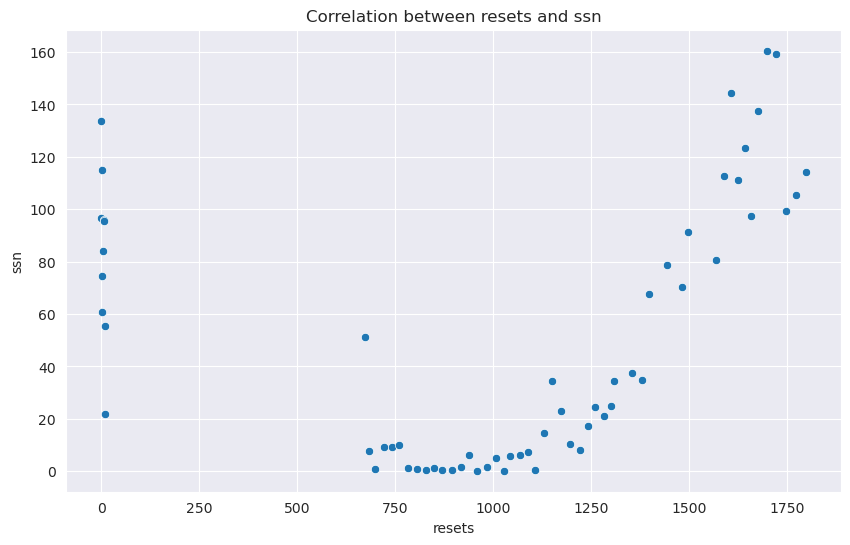

Analysis results:
Spearman's rank correlation: 0.38012670904971924
Kendall's tau: 0.3122172445117302
Correlation:  0.19829777102215387
          resets       ssn
resets  1.000000  0.198298
ssn     0.198298  1.000000


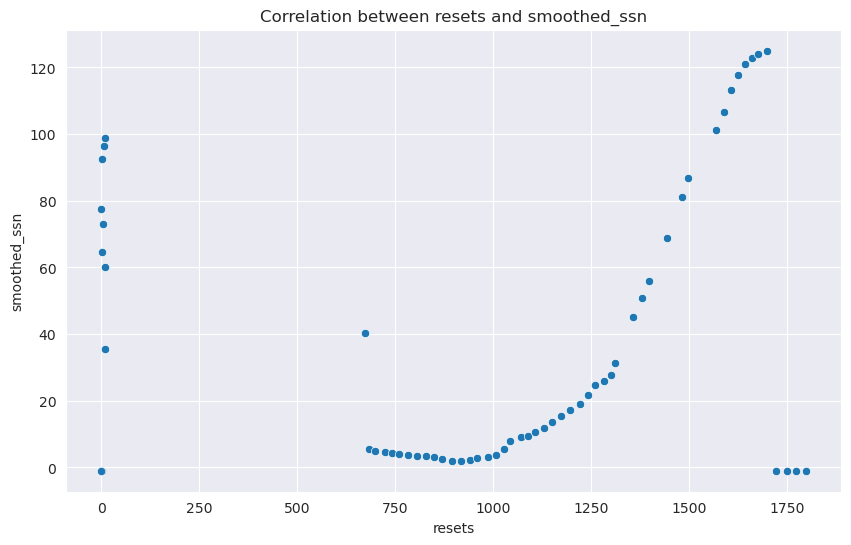

Analysis results:
Spearman's rank correlation: 0.21487548268535822
Kendall's tau: 0.2553936158761771
Correlation:  0.13168100772246627
                resets  smoothed_ssn
resets        1.000000      0.131681
smoothed_ssn  0.131681      1.000000


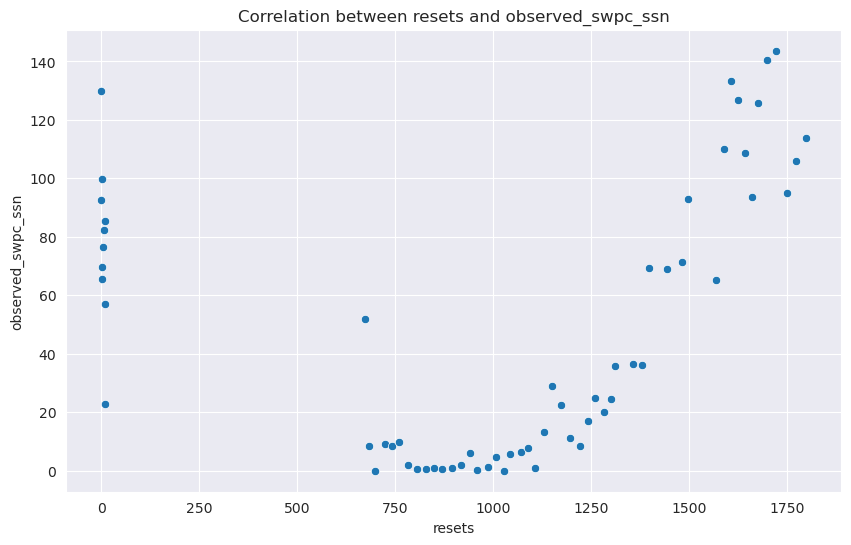

Analysis results:
Spearman's rank correlation: 0.39284176105244023
Kendall's tau: 0.3203171265166223
Correlation:  0.20802247306709154
                     resets  observed_swpc_ssn
resets             1.000000           0.208022
observed_swpc_ssn  0.208022           1.000000


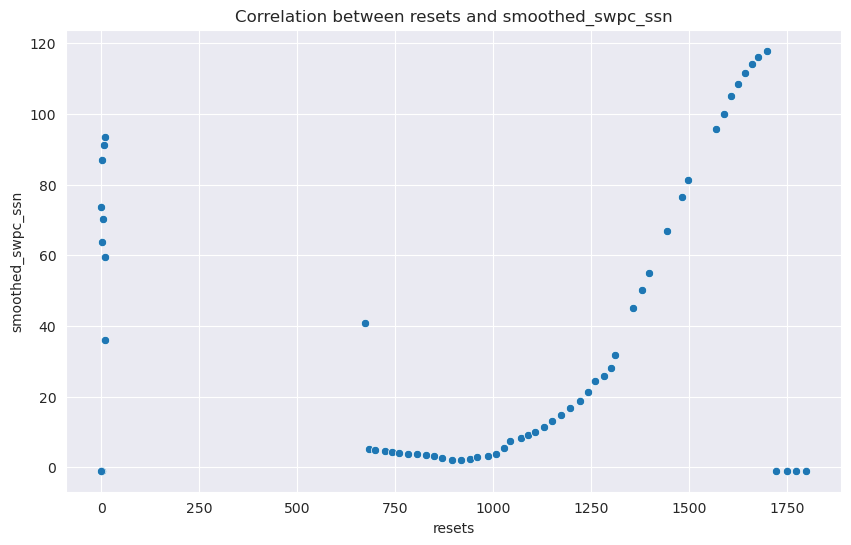

Analysis results:
Spearman's rank correlation: 0.2146282727614569
Kendall's tau: 0.2548987055691801
Correlation:  0.12260484147449434
                     resets  smoothed_swpc_ssn
resets             1.000000           0.122605
smoothed_swpc_ssn  0.122605           1.000000


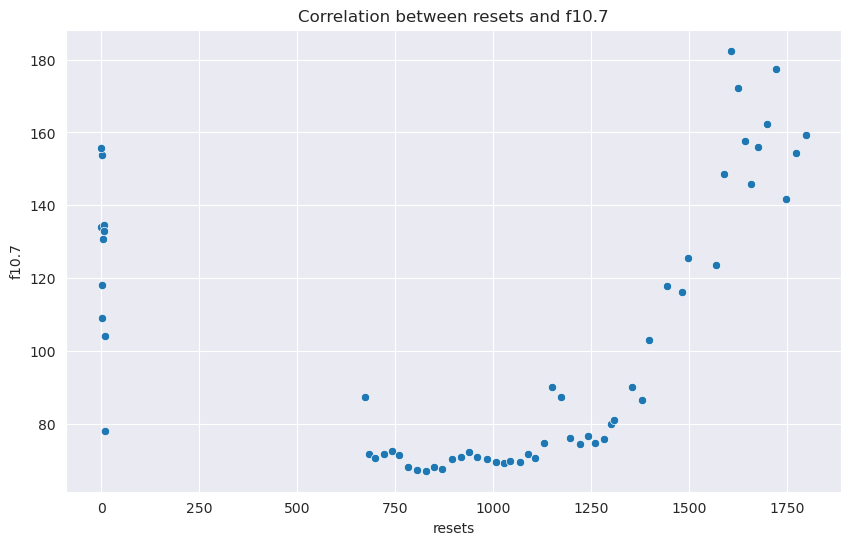

Analysis results:
Spearman's rank correlation: 0.39564317374162356
Kendall's tau: 0.31025714716982605
Correlation:  0.21522626002780323
          resets     f10.7
resets  1.000000  0.215226
f10.7   0.215226  1.000000


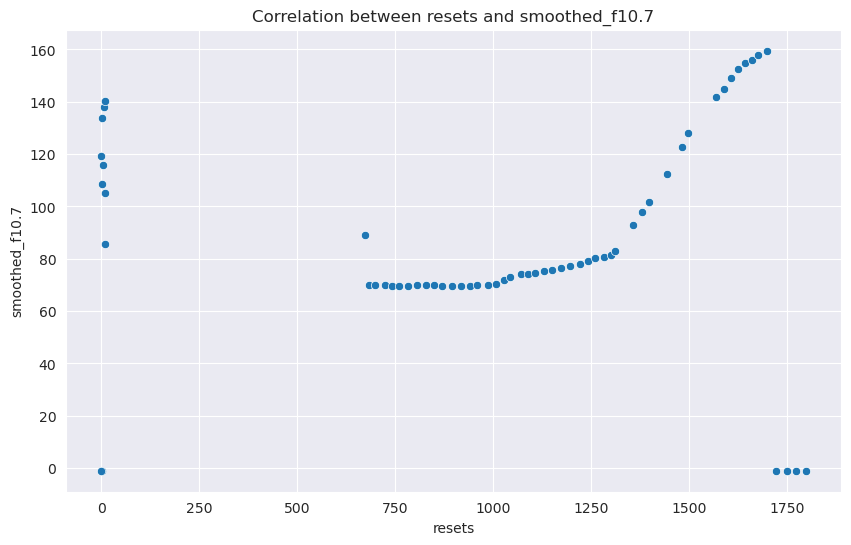

Analysis results:
Spearman's rank correlation: 0.22873715836197772
Kendall's tau: 0.2956510093789305
Correlation:  0.05410464327920527
                  resets  smoothed_f10.7
resets          1.000000        0.054105
smoothed_f10.7  0.054105        1.000000


In [408]:
analyze_griffex('resets.csv', 'resets', 'ssn')
analyze_griffex('resets.csv', 'resets', 'smoothed_ssn')
analyze_griffex('resets.csv', 'resets', 'observed_swpc_ssn')
analyze_griffex('resets.csv', 'resets', 'smoothed_swpc_ssn')
analyze_griffex('resets.csv', 'resets', 'f10.7')
analyze_griffex('resets.csv', 'resets', 'smoothed_f10.7')

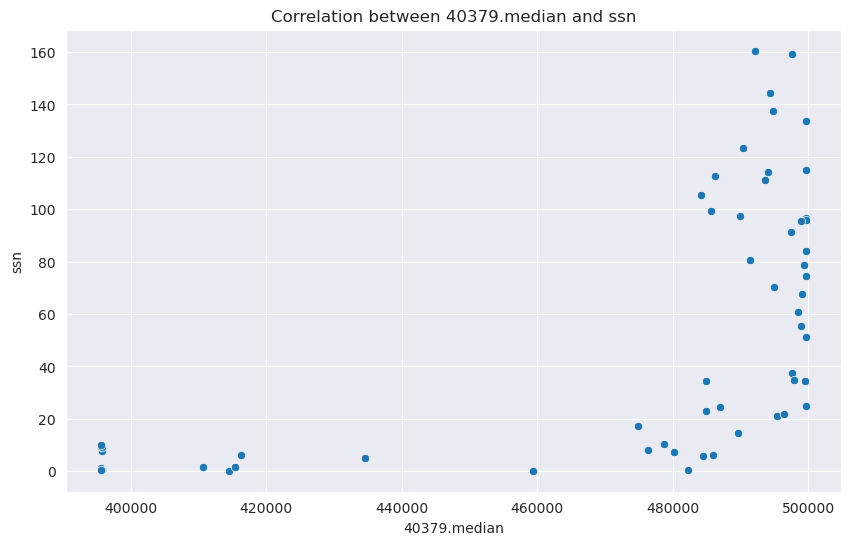

Analysis results:
Spearman's rank correlation: 0.7163503059493702
Kendall's tau: 0.5018439143801292
Correlation:  0.6243048605874743
              40379.median       ssn
40379.median      1.000000  0.624305
ssn               0.624305  1.000000


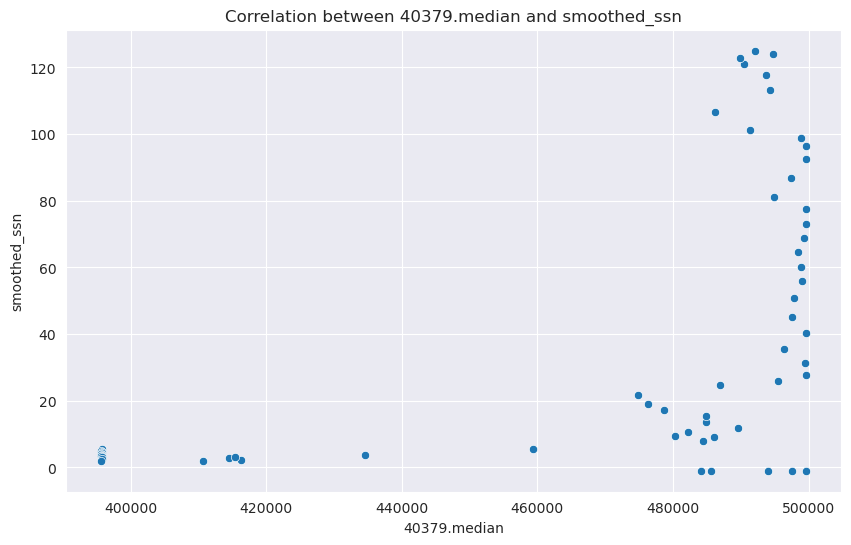

Analysis results:
Spearman's rank correlation: 0.5155012016313268
Kendall's tau: 0.3596020707860973
Correlation:  0.5355421465189284
              40379.median  smoothed_ssn
40379.median      1.000000      0.535542
smoothed_ssn      0.535542      1.000000


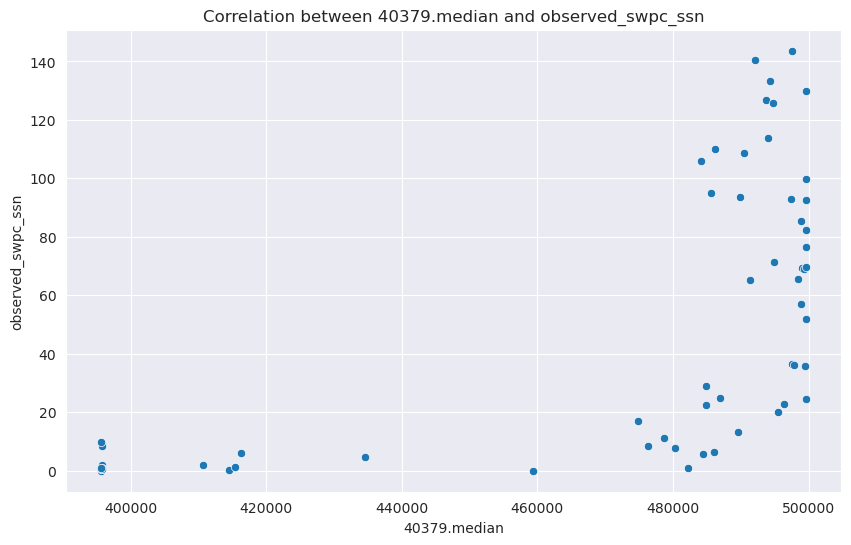

Analysis results:
Spearman's rank correlation: 0.7167970706017049
Kendall's tau: 0.5032629176230278
Correlation:  0.6321956901806866
                   40379.median  observed_swpc_ssn
40379.median           1.000000           0.632196
observed_swpc_ssn      0.632196           1.000000


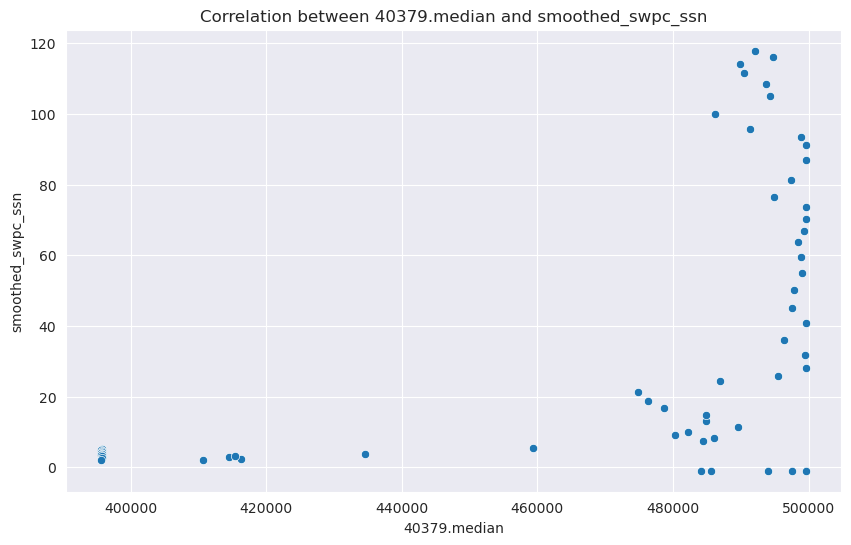

Analysis results:
Spearman's rank correlation: 0.5153137340948172
Kendall's tau: 0.3591354125284485
Correlation:  0.5433229628854387
                   40379.median  smoothed_swpc_ssn
40379.median           1.000000           0.543323
smoothed_swpc_ssn      0.543323           1.000000


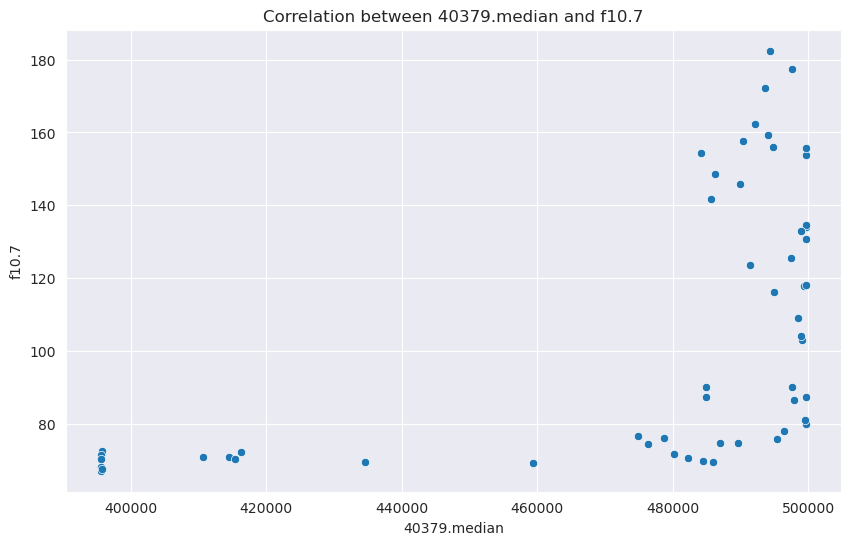

Analysis results:
Spearman's rank correlation: 0.6976447035447789
Kendall's tau: 0.48725407978178686
Correlation:  0.5811577558184146
              40379.median     f10.7
40379.median      1.000000  0.581158
f10.7             0.581158  1.000000


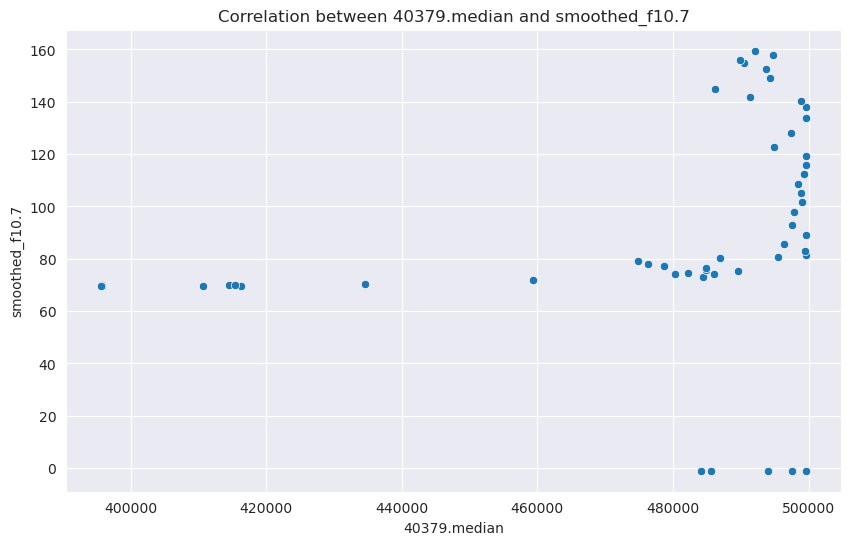

Analysis results:
Spearman's rank correlation: 0.5260963016668757
Kendall's tau: 0.3877835347532134
Correlation:  0.26696916594408804
                40379.median  smoothed_f10.7
40379.median        1.000000        0.266969
smoothed_f10.7      0.266969        1.000000


In [409]:
analyze_griffex('data_mnt_usage.csv', '40379.median', 'ssn')
analyze_griffex('data_mnt_usage.csv', '40379.median', 'smoothed_ssn')
analyze_griffex('data_mnt_usage.csv', '40379.median', 'observed_swpc_ssn')
analyze_griffex('data_mnt_usage.csv', '40379.median', 'smoothed_swpc_ssn')
analyze_griffex('data_mnt_usage.csv', '40379.median', 'f10.7')
analyze_griffex('data_mnt_usage.csv', '40379.median', 'smoothed_f10.7')

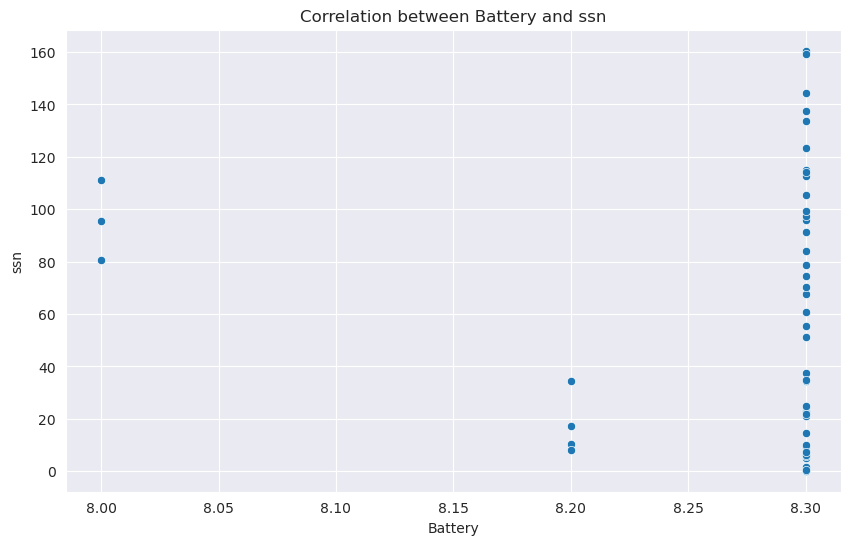

Analysis results:
Spearman's rank correlation: -0.08303782254463078
Kendall's tau: -0.07171902055538998
Correlation:  -0.13972807193454626
          Battery       ssn
Battery  1.000000 -0.139728
ssn     -0.139728  1.000000


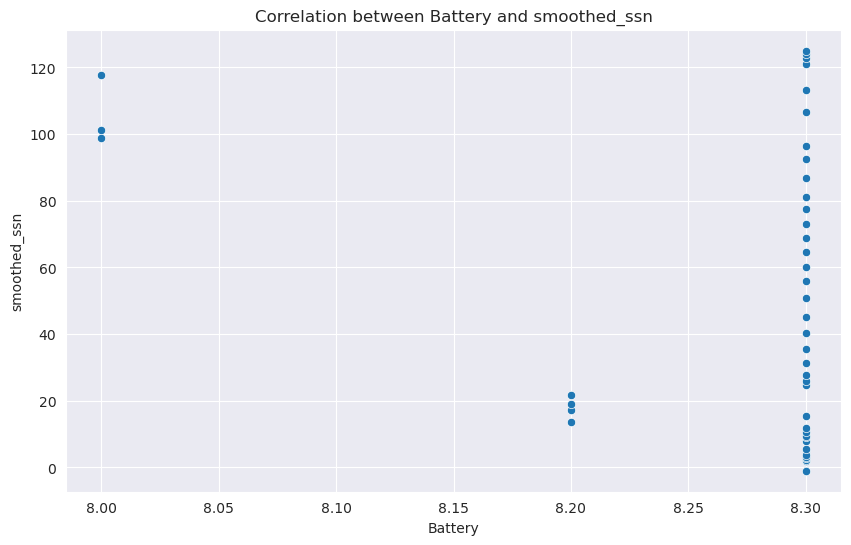

Analysis results:
Spearman's rank correlation: -0.23046387095990112
Kendall's tau: -0.19149688109734606
Correlation:  -0.3107871416588979
               Battery  smoothed_ssn
Battery       1.000000     -0.310787
smoothed_ssn -0.310787      1.000000


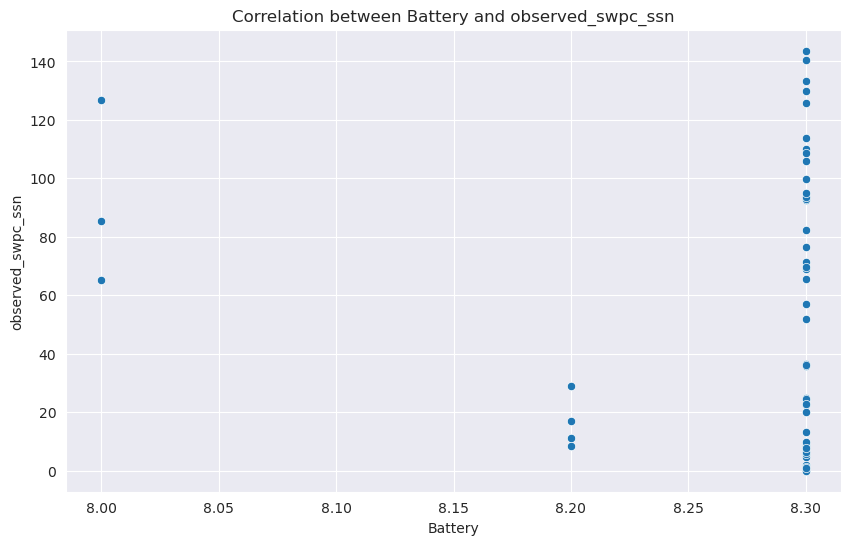

Analysis results:
Spearman's rank correlation: -0.08019842915534707
Kendall's tau: -0.0693271127837246
Correlation:  -0.14741505568840838
                    Battery  observed_swpc_ssn
Battery            1.000000          -0.147415
observed_swpc_ssn -0.147415           1.000000


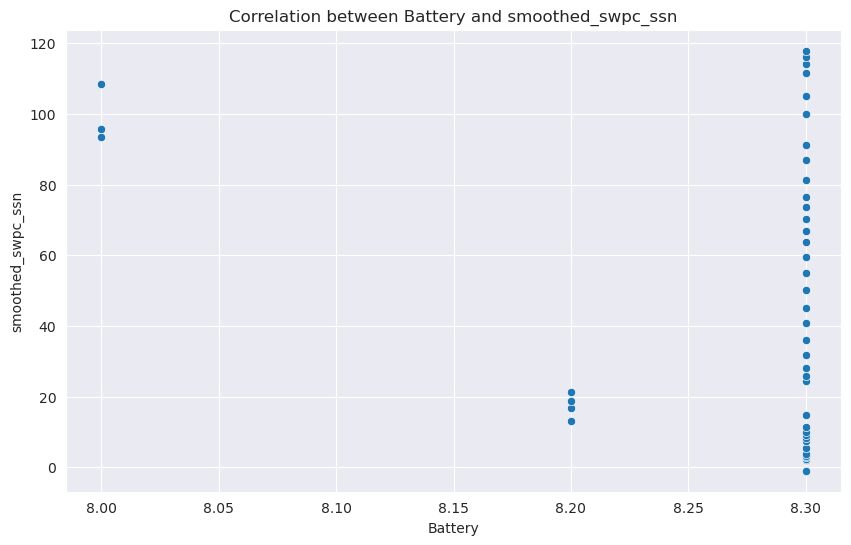

Analysis results:
Spearman's rank correlation: -0.23046707591996798
Kendall's tau: -0.19155146193958233
Correlation:  -0.30676039183936116
                   Battery  smoothed_swpc_ssn
Battery            1.00000           -0.30676
smoothed_swpc_ssn -0.30676            1.00000


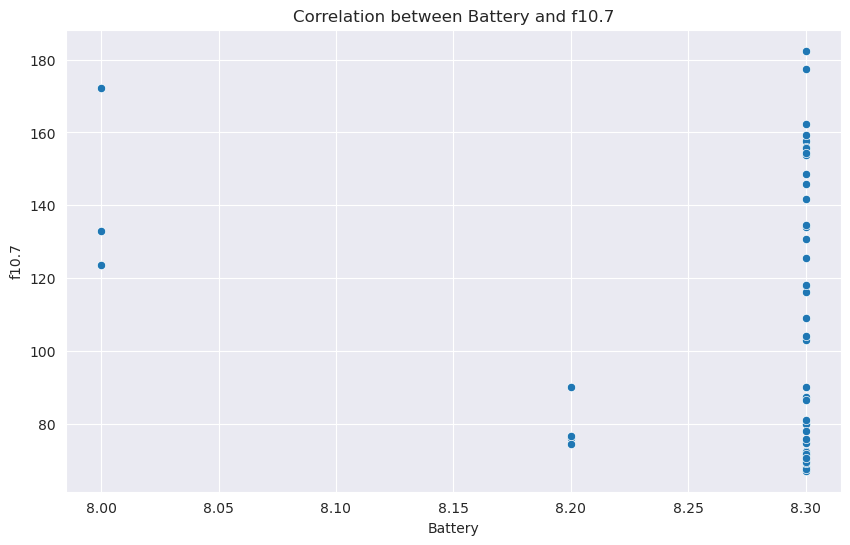

Analysis results:
Spearman's rank correlation: -0.13664513560910088
Kendall's tau: -0.11538187313793137
Correlation:  -0.1867031483558193
          Battery     f10.7
Battery  1.000000 -0.186703
f10.7   -0.186703  1.000000


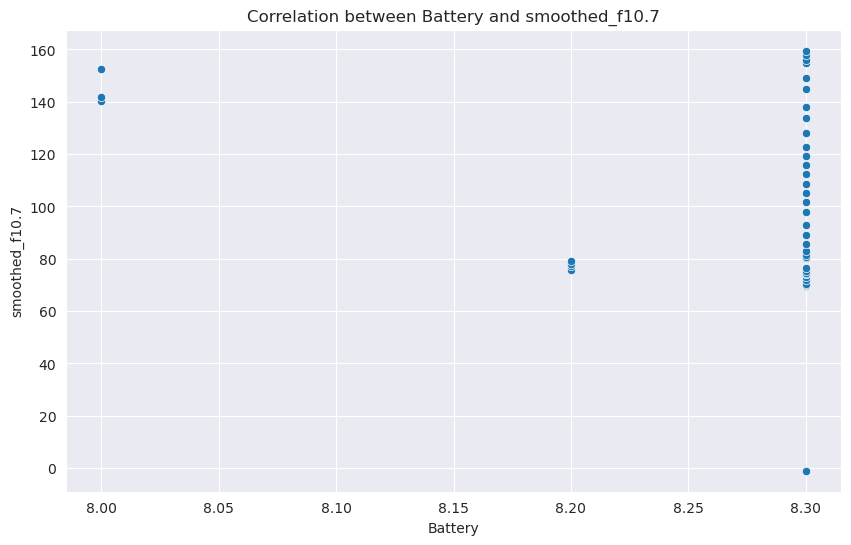

Analysis results:
Spearman's rank correlation: -0.23053761888746685
Kendall's tau: -0.19221009355148566
Correlation:  -0.2922258172729578
                 Battery  smoothed_f10.7
Battery         1.000000       -0.292226
smoothed_f10.7 -0.292226        1.000000


In [410]:
analyze_griffex('battery.csv', 'Battery', 'ssn')
analyze_griffex('battery.csv', 'Battery', 'smoothed_ssn')
analyze_griffex('battery.csv', 'Battery', 'observed_swpc_ssn')
analyze_griffex('battery.csv', 'Battery', 'smoothed_swpc_ssn')
analyze_griffex('battery.csv', 'Battery', 'f10.7')
analyze_griffex('battery.csv', 'Battery', 'smoothed_f10.7')

/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


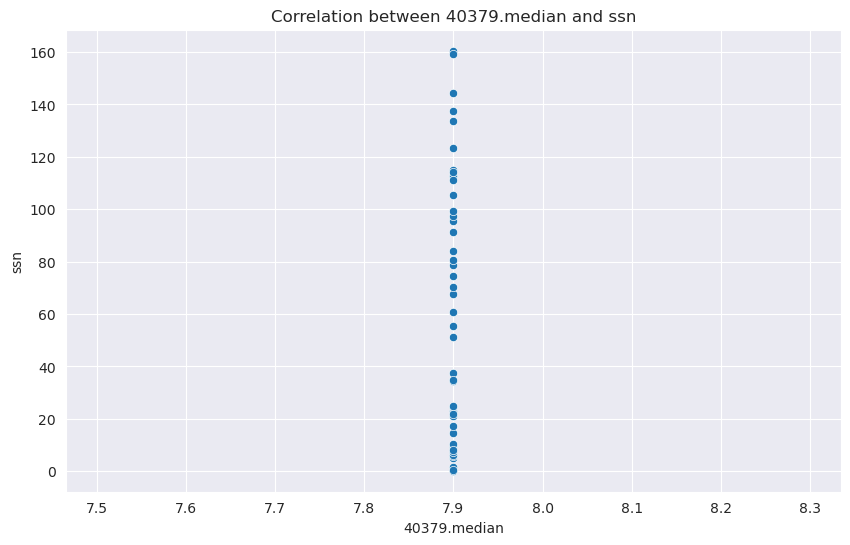

Analysis results:
Spearman's rank correlation: nan
Kendall's tau: nan
Correlation:  2.8928015357738235e-17
              40379.median  ssn
40379.median           NaN  NaN
ssn                    NaN  1.0


/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


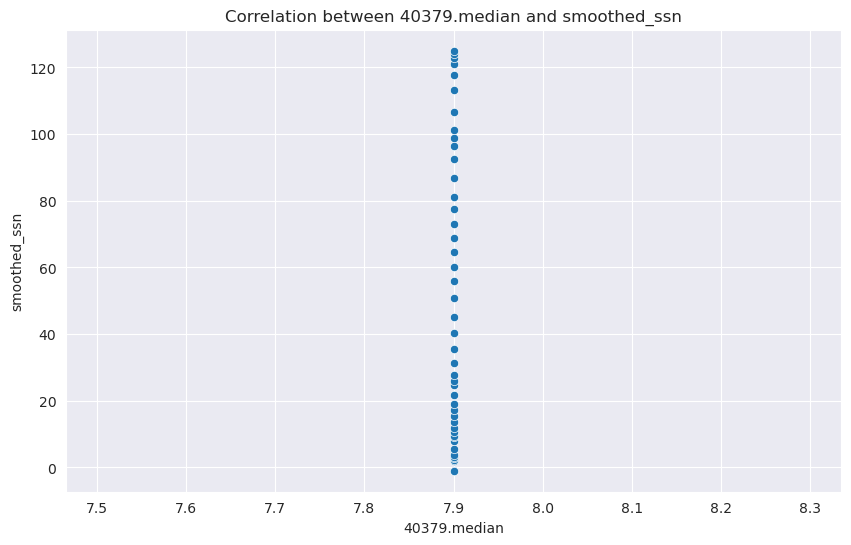

Analysis results:
Spearman's rank correlation: nan
Kendall's tau: nan
Correlation:  3.76514328421923e-18
              40379.median  smoothed_ssn
40379.median           NaN           NaN
smoothed_ssn           NaN           1.0


/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


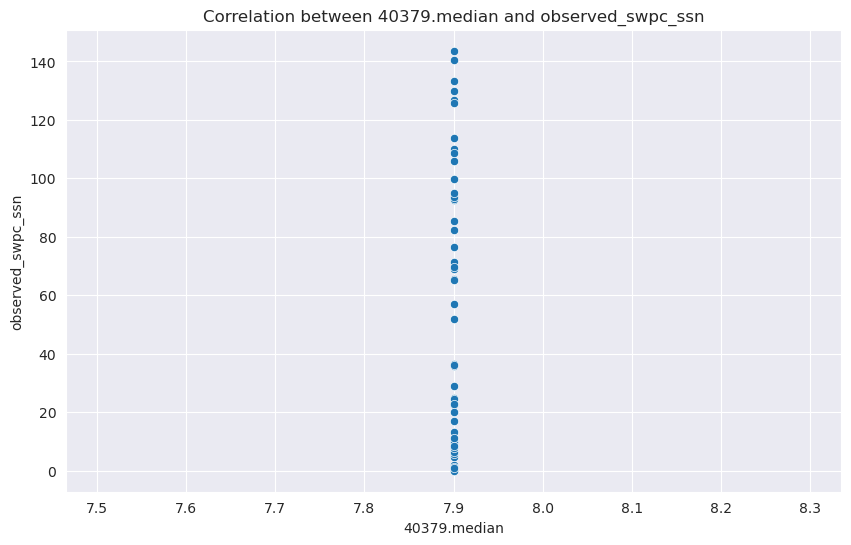

Analysis results:
Spearman's rank correlation: nan
Kendall's tau: nan
Correlation:  4.8105662410419635e-17
                   40379.median  observed_swpc_ssn
40379.median                NaN                NaN
observed_swpc_ssn           NaN                1.0


/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


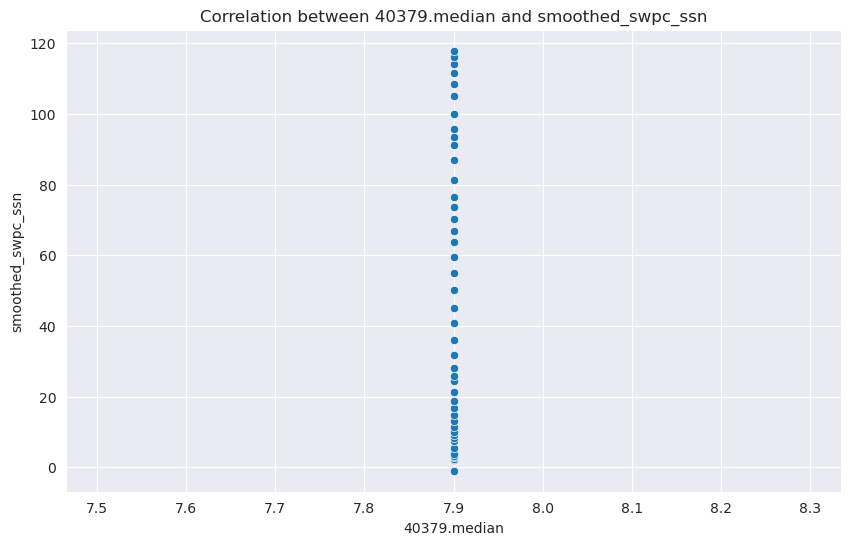

Analysis results:
Spearman's rank correlation: nan
Kendall's tau: nan
Correlation:  6.426718068920605e-17
                   40379.median  smoothed_swpc_ssn
40379.median                NaN                NaN
smoothed_swpc_ssn           NaN                1.0


/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


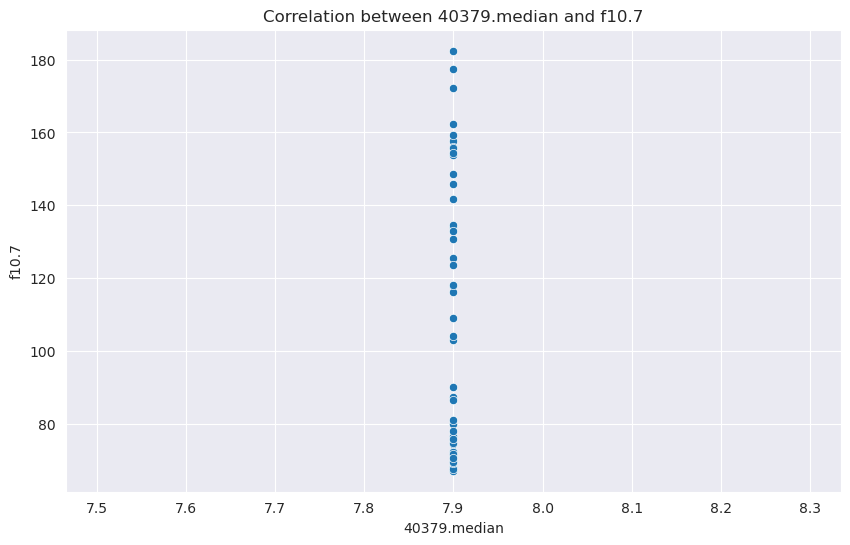

Analysis results:
Spearman's rank correlation: nan
Kendall's tau: nan
Correlation:  3.2417595354086603e-16
              40379.median  f10.7
40379.median           NaN    NaN
f10.7                  NaN    1.0


/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


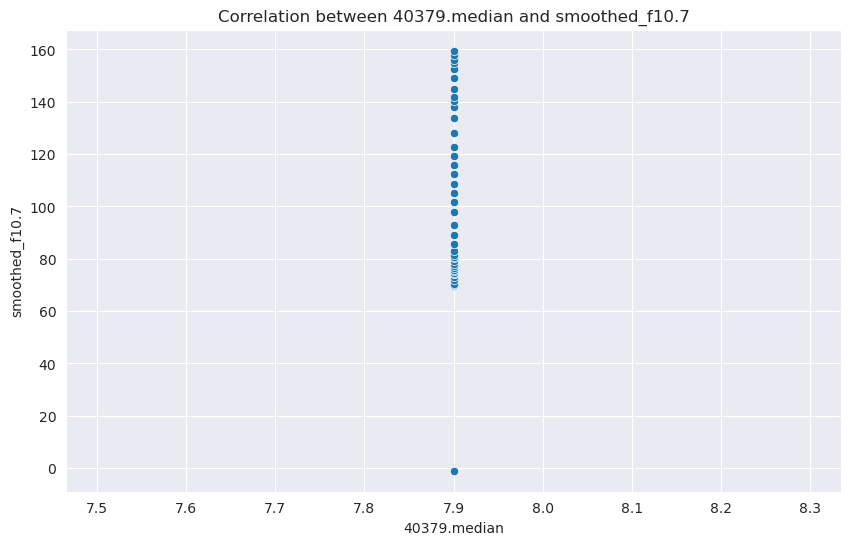

Analysis results:
Spearman's rank correlation: nan
Kendall's tau: nan
Correlation:  -6.150202922174086e-17
                40379.median  smoothed_f10.7
40379.median             NaN             NaN
smoothed_f10.7           NaN             1.0


In [411]:
analyze_griffex('memory_median.csv', '40379.median', 'ssn')
analyze_griffex('memory_median.csv', '40379.median', 'smoothed_ssn')
analyze_griffex('memory_median.csv', '40379.median', 'observed_swpc_ssn')
analyze_griffex('memory_median.csv', '40379.median', 'smoothed_swpc_ssn')
analyze_griffex('memory_median.csv', '40379.median', 'f10.7')
analyze_griffex('memory_median.csv', '40379.median', 'smoothed_f10.7')

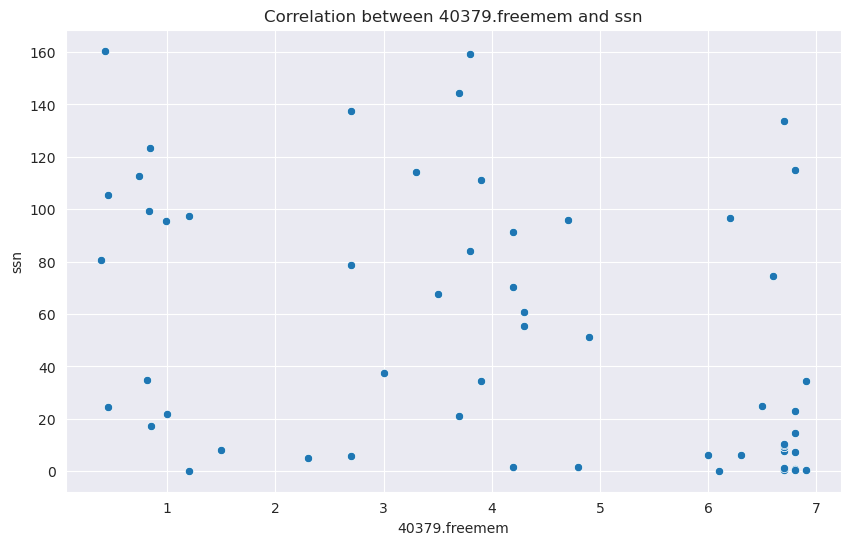

Analysis results:
Spearman's rank correlation: -0.470200970540779
Kendall's tau: -0.33629457280083896
Correlation:  -0.4171539430821123
               40379.freemem       ssn
40379.freemem       1.000000 -0.417154
ssn                -0.417154  1.000000


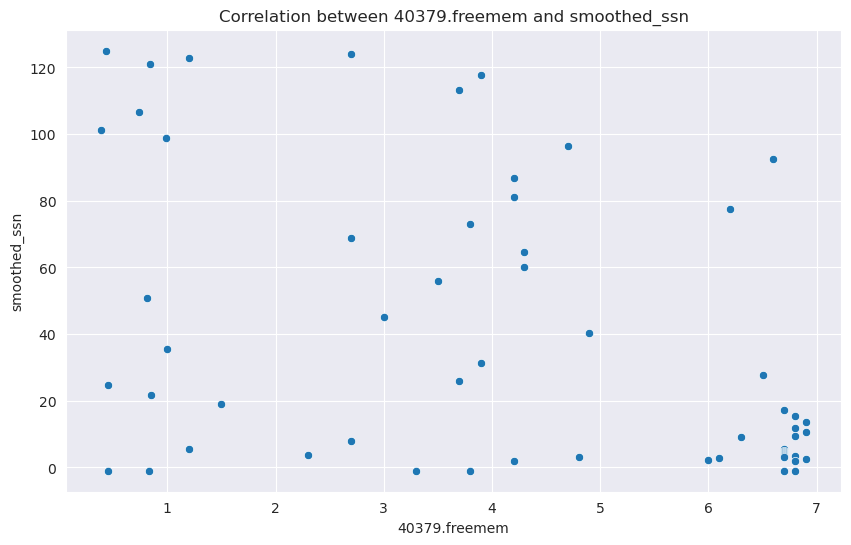

Analysis results:
Spearman's rank correlation: -0.4225758591535156
Kendall's tau: -0.28642012982340154
Correlation:  -0.45674100572623005
               40379.freemem  smoothed_ssn
40379.freemem       1.000000     -0.456741
smoothed_ssn       -0.456741      1.000000


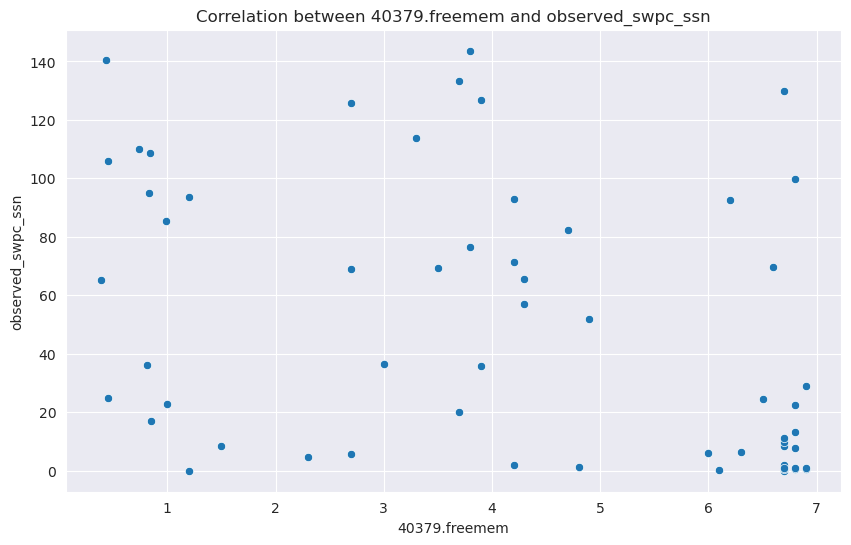

Analysis results:
Spearman's rank correlation: -0.4675030159062552
Kendall's tau: -0.32492199374841163
Correlation:  -0.4138804527967414
                   40379.freemem  observed_swpc_ssn
40379.freemem            1.00000           -0.41388
observed_swpc_ssn       -0.41388            1.00000


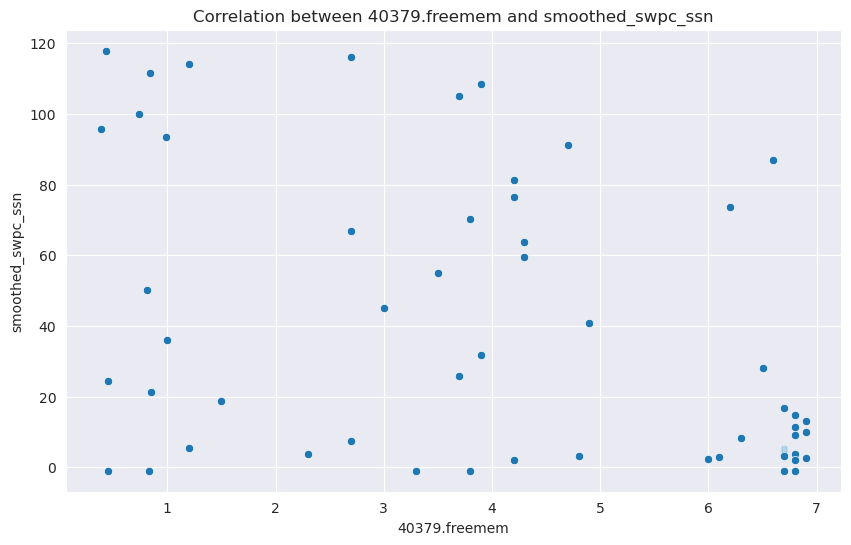

Analysis results:
Spearman's rank correlation: -0.4214803184717404
Kendall's tau: -0.28592180280001006
Correlation:  -0.45987879739450194
                   40379.freemem  smoothed_swpc_ssn
40379.freemem           1.000000          -0.459879
smoothed_swpc_ssn      -0.459879           1.000000


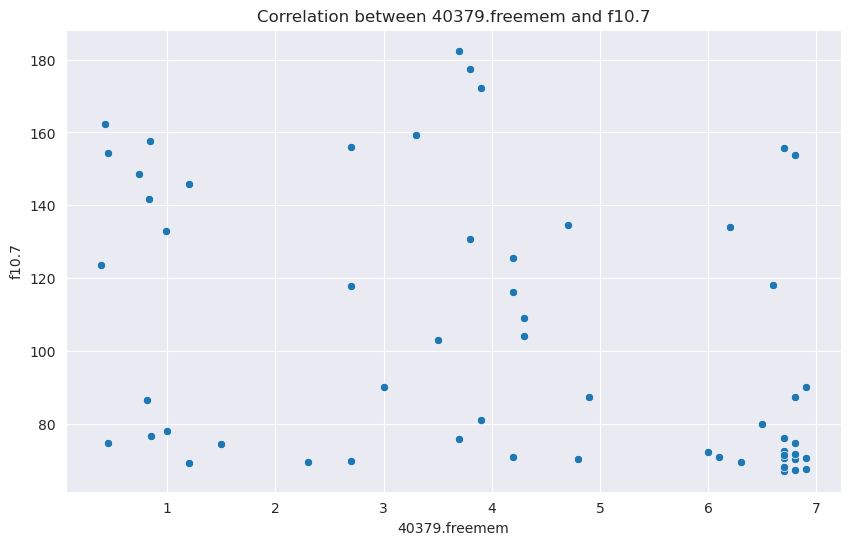

Analysis results:
Spearman's rank correlation: -0.45486679045866757
Kendall's tau: -0.32042138896564737
Correlation:  -0.3946828262024892
               40379.freemem     f10.7
40379.freemem       1.000000 -0.394683
f10.7              -0.394683  1.000000


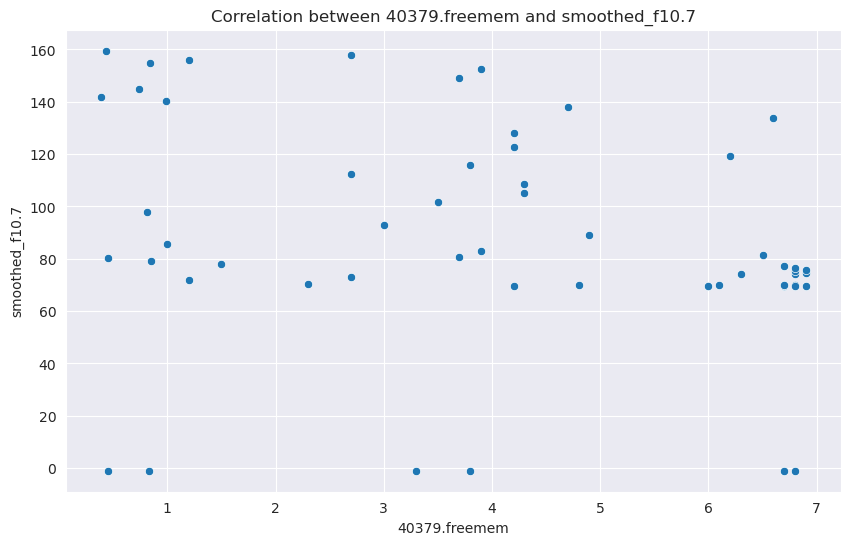

Analysis results:
Spearman's rank correlation: -0.442096381226385
Kendall's tau: -0.30785537845422567
Correlation:  -0.28521257406656064
                40379.freemem  smoothed_f10.7
40379.freemem        1.000000       -0.285213
smoothed_f10.7      -0.285213        1.000000


In [412]:
analyze_griffex('memory_free_median.csv', '40379.freemem', 'ssn')
analyze_griffex('memory_free_median.csv', '40379.freemem', 'smoothed_ssn')
analyze_griffex('memory_free_median.csv', '40379.freemem', 'observed_swpc_ssn')
analyze_griffex('memory_free_median.csv', '40379.freemem', 'smoothed_swpc_ssn')
analyze_griffex('memory_free_median.csv', '40379.freemem', 'f10.7')
analyze_griffex('memory_free_median.csv', '40379.freemem', 'smoothed_f10.7')

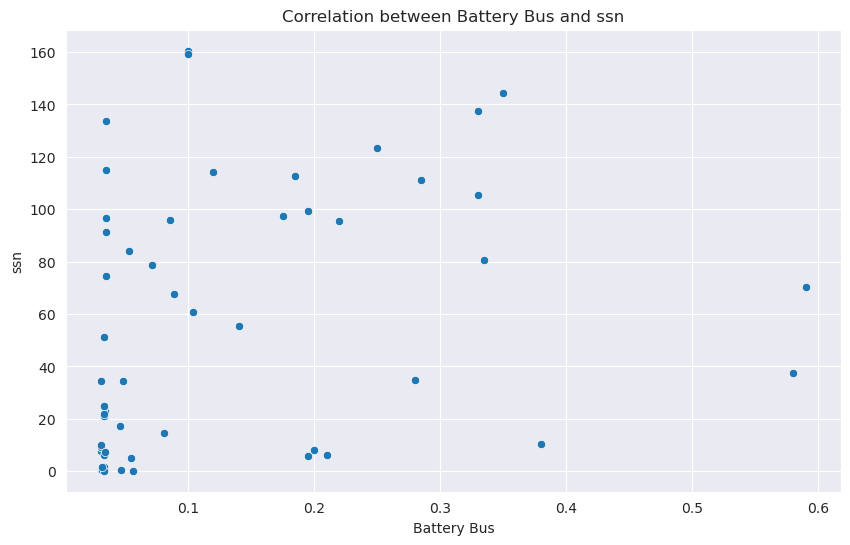

Analysis results:
Spearman's rank correlation: 0.5803568962663838
Kendall's tau: 0.4049767733768524
Correlation:  0.34306849393439953
             Battery Bus       ssn
Battery Bus     1.000000  0.343068
ssn             0.343068  1.000000


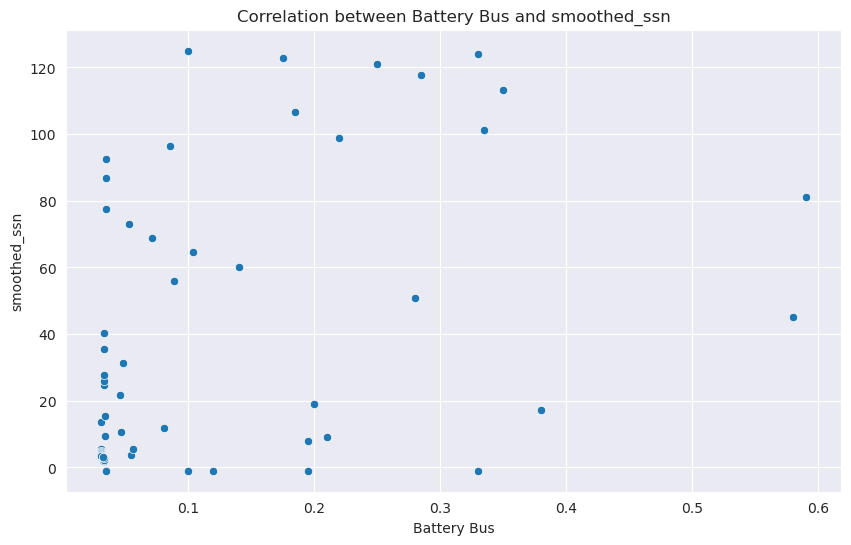

Analysis results:
Spearman's rank correlation: 0.4851010276630374
Kendall's tau: 0.3243895486139028
Correlation:  0.42817412485261824
              Battery Bus  smoothed_ssn
Battery Bus      1.000000      0.428174
smoothed_ssn     0.428174      1.000000


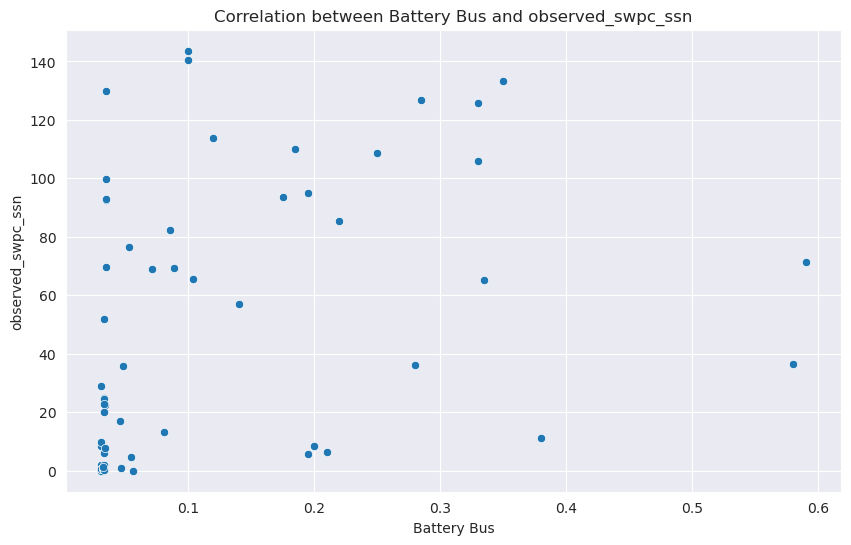

Analysis results:
Spearman's rank correlation: 0.588494211778555
Kendall's tau: 0.4133218740325417
Correlation:  0.3559943732328977
                   Battery Bus  observed_swpc_ssn
Battery Bus           1.000000           0.355994
observed_swpc_ssn     0.355994           1.000000


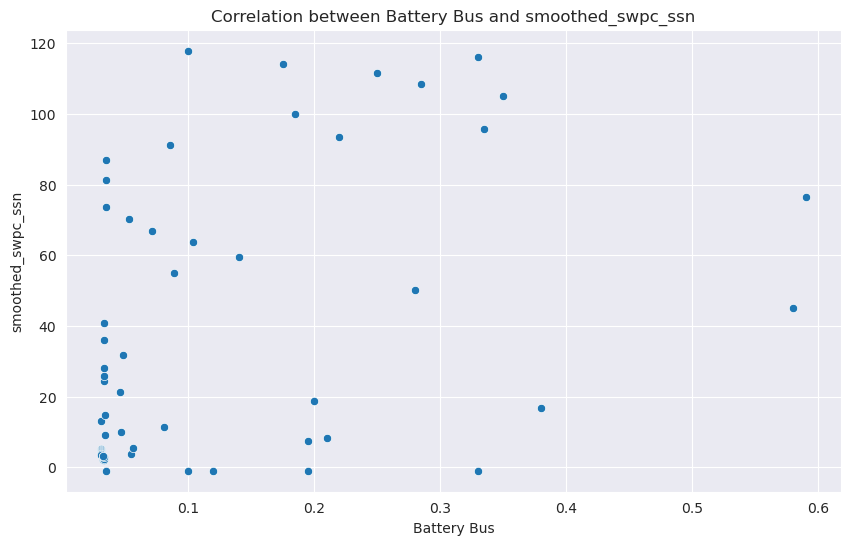

Analysis results:
Spearman's rank correlation: 0.4843268039264007
Kendall's tau: 0.3239004978298801
Correlation:  0.42587873675059357
                   Battery Bus  smoothed_swpc_ssn
Battery Bus           1.000000           0.425879
smoothed_swpc_ssn     0.425879           1.000000


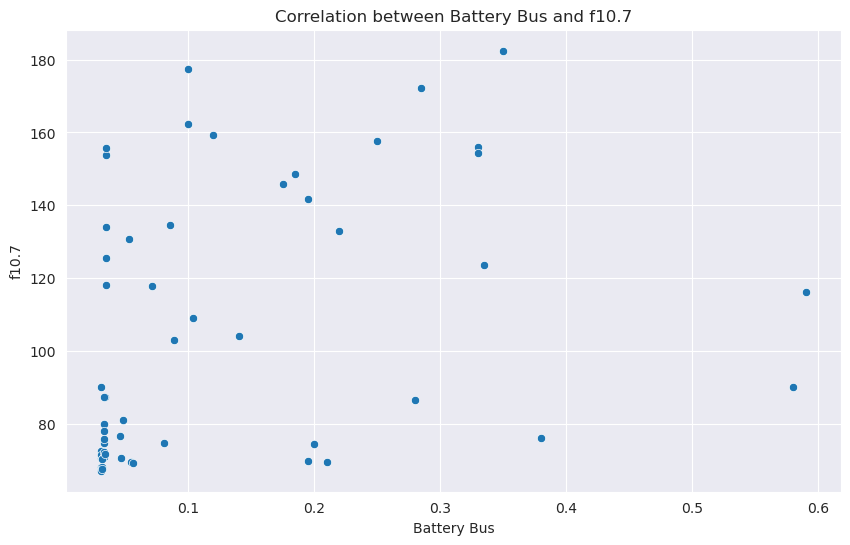

Analysis results:
Spearman's rank correlation: 0.5929613627637287
Kendall's tau: 0.4283672905705466
Correlation:  0.3728133540650135
             Battery Bus     f10.7
Battery Bus     1.000000  0.372813
f10.7           0.372813  1.000000


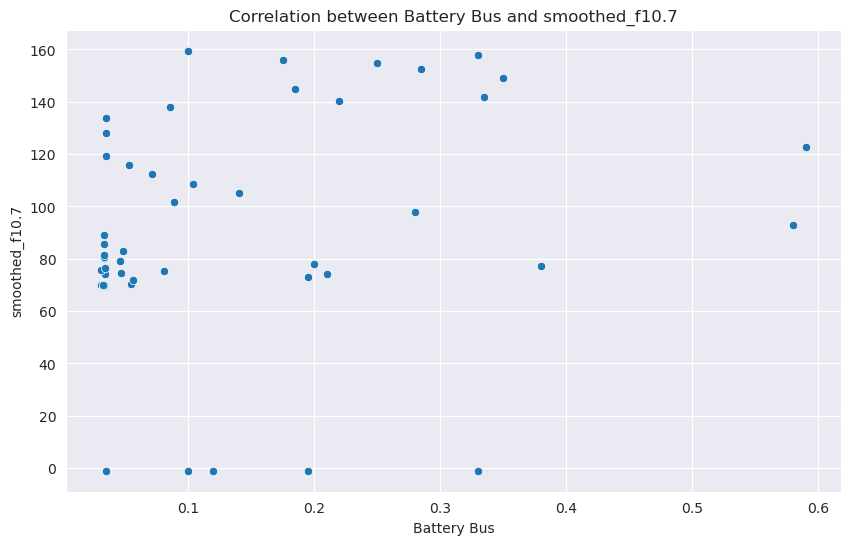

Analysis results:
Spearman's rank correlation: 0.5028195083043857
Kendall's tau: 0.3541896209252578
Correlation:  0.2931480075767957
                Battery Bus  smoothed_f10.7
Battery Bus        1.000000        0.293148
smoothed_f10.7     0.293148        1.000000


In [413]:
analyze_griffex('bus_current.csv', 'Battery Bus', 'ssn')
analyze_griffex('bus_current.csv', 'Battery Bus', 'smoothed_ssn')
analyze_griffex('bus_current.csv', 'Battery Bus', 'observed_swpc_ssn')
analyze_griffex('bus_current.csv', 'Battery Bus', 'smoothed_swpc_ssn')
analyze_griffex('bus_current.csv', 'Battery Bus', 'f10.7')
analyze_griffex('bus_current.csv', 'Battery Bus', 'smoothed_f10.7')

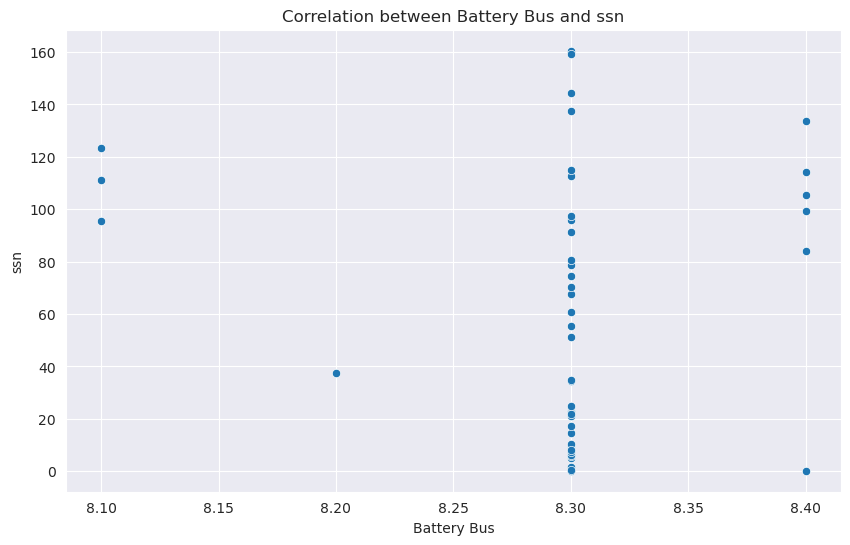

Analysis results:
Spearman's rank correlation: 0.01890182419506821
Kendall's tau: 0.010362783325858637
Correlation:  -0.06683376633403207
             Battery Bus       ssn
Battery Bus     1.000000 -0.066834
ssn            -0.066834  1.000000


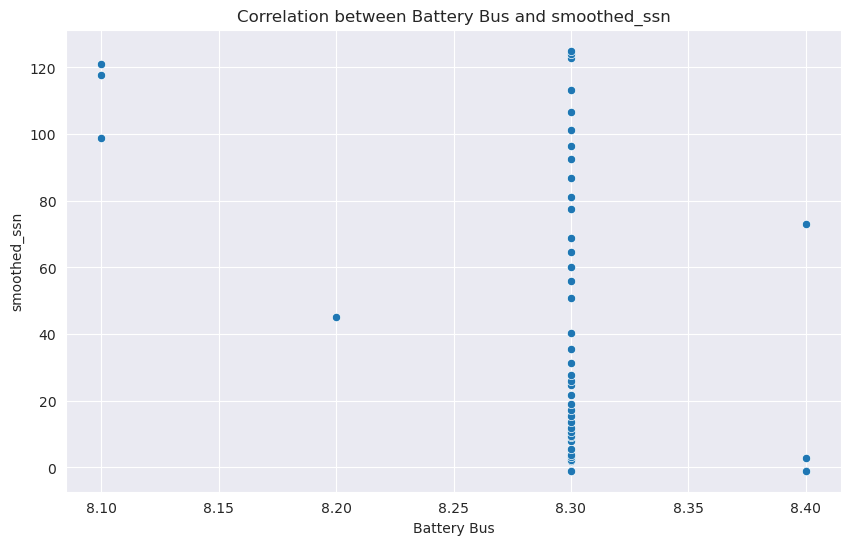

Analysis results:
Spearman's rank correlation: -0.4630648824912795
Kendall's tau: -0.38577141285375294
Correlation:  -0.4318836359962252
              Battery Bus  smoothed_ssn
Battery Bus      1.000000     -0.431884
smoothed_ssn    -0.431884      1.000000


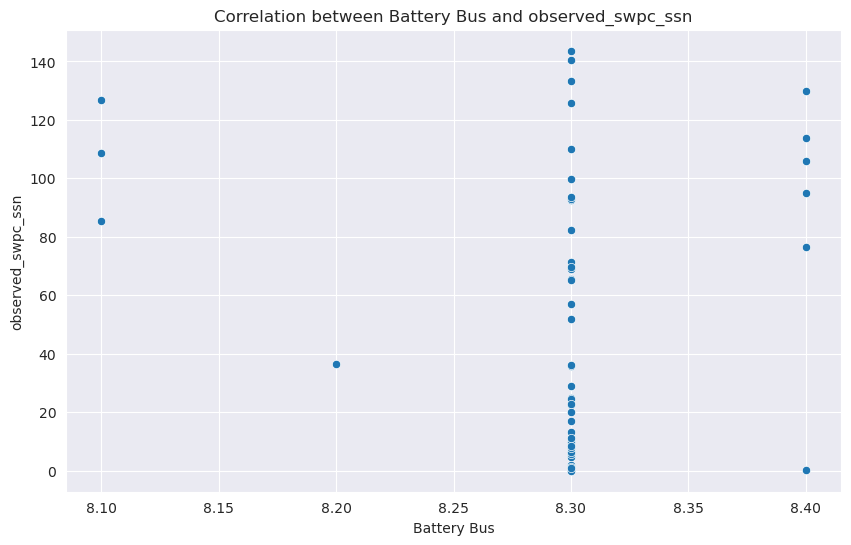

Analysis results:
Spearman's rank correlation: 0.024989167476471796
Kendall's tau: 0.015552979393339167
Correlation:  -0.07029979246495732
                   Battery Bus  observed_swpc_ssn
Battery Bus             1.0000            -0.0703
observed_swpc_ssn      -0.0703             1.0000


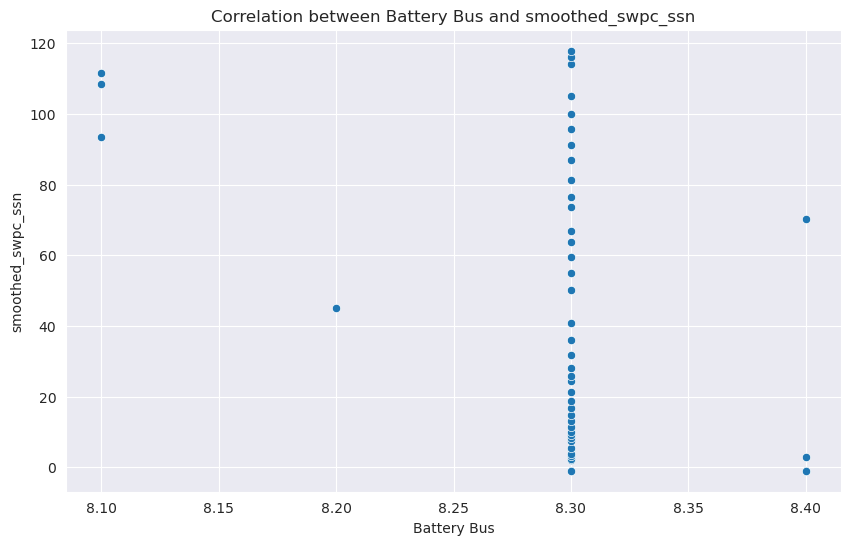

Analysis results:
Spearman's rank correlation: -0.4630713221316906
Kendall's tau: -0.3858813662300355
Correlation:  -0.42751678879603255
                   Battery Bus  smoothed_swpc_ssn
Battery Bus           1.000000          -0.427517
smoothed_swpc_ssn    -0.427517           1.000000


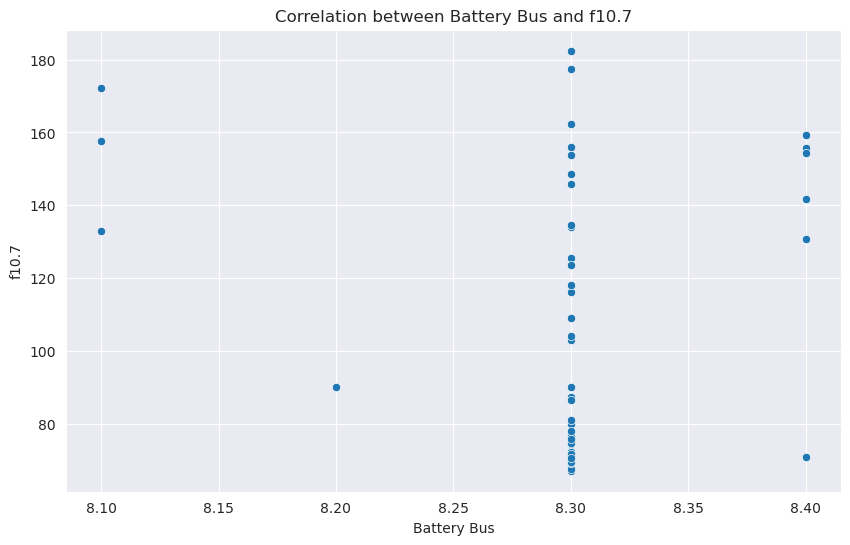

Analysis results:
Spearman's rank correlation: 0.03720203986654775
Kendall's tau: 0.030026592987043806
Correlation:  -0.08261104839657904
             Battery Bus     f10.7
Battery Bus     1.000000 -0.082611
f10.7          -0.082611  1.000000


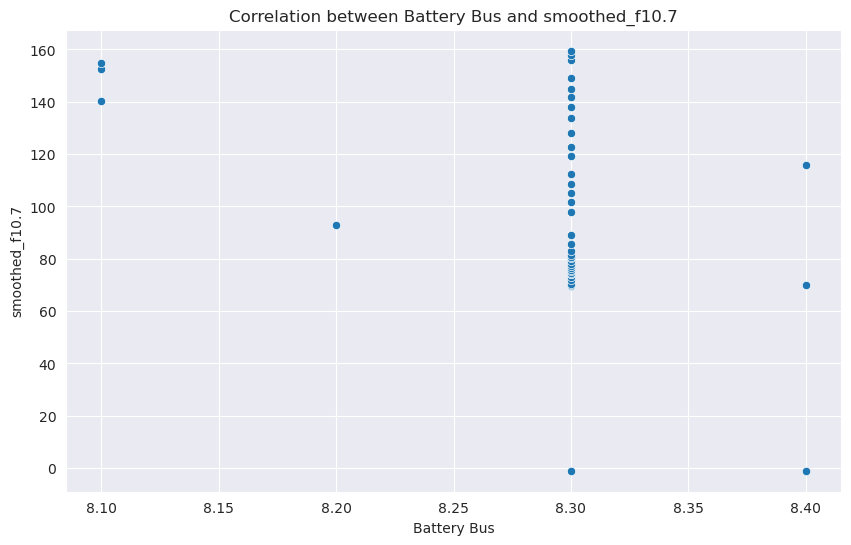

Analysis results:
Spearman's rank correlation: -0.4512027226189621
Kendall's tau: -0.3767713046211193
Correlation:  -0.5197758921276953
                Battery Bus  smoothed_f10.7
Battery Bus        1.000000       -0.519776
smoothed_f10.7    -0.519776        1.000000


In [414]:
analyze_griffex('bus_voltage.csv', 'Battery Bus', 'ssn')
analyze_griffex('bus_voltage.csv', 'Battery Bus', 'smoothed_ssn')
analyze_griffex('bus_voltage.csv', 'Battery Bus', 'observed_swpc_ssn')
analyze_griffex('bus_voltage.csv', 'Battery Bus', 'smoothed_swpc_ssn')
analyze_griffex('bus_voltage.csv', 'Battery Bus', 'f10.7')
analyze_griffex('bus_voltage.csv', 'Battery Bus', 'smoothed_f10.7')

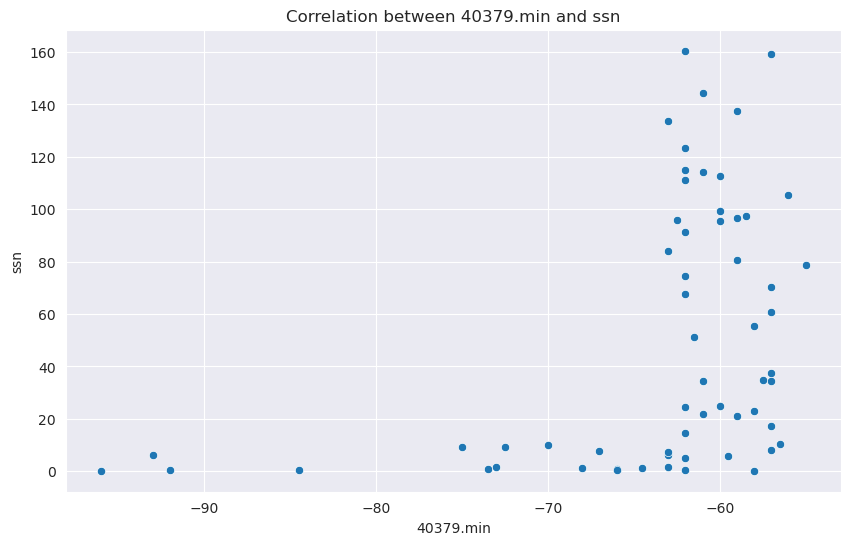

Analysis results:
Spearman's rank correlation: 0.4594861539400232
Kendall's tau: 0.307522453365607
Correlation:  0.3932620686033009
           40379.min       ssn
40379.min   1.000000  0.393262
ssn         0.393262  1.000000


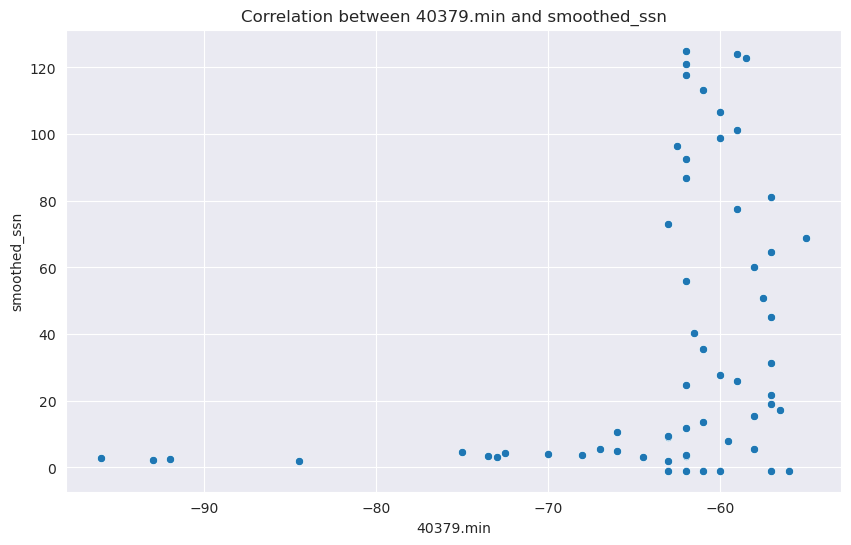

Analysis results:
Spearman's rank correlation: 0.3915748252677913
Kendall's tau: 0.2734404816994579
Correlation:  0.3419826250399543
              40379.min  smoothed_ssn
40379.min      1.000000      0.341983
smoothed_ssn   0.341983      1.000000


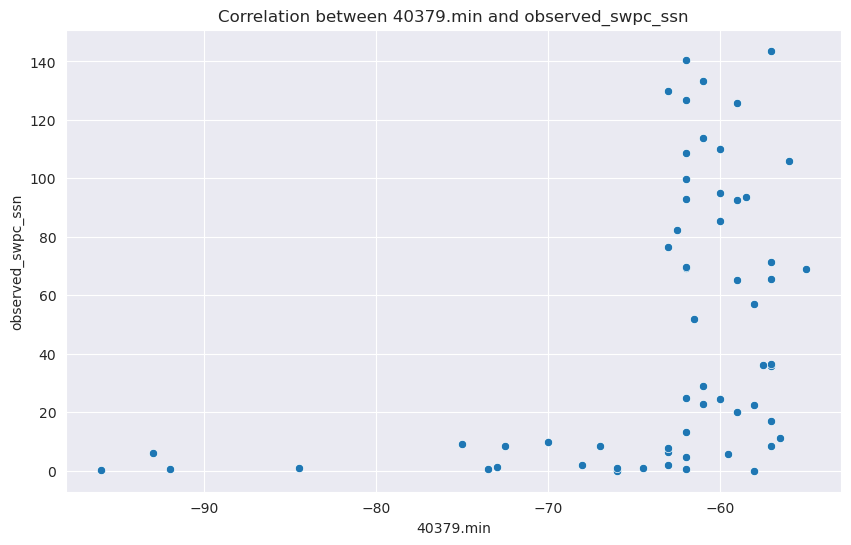

Analysis results:
Spearman's rank correlation: 0.4578442765819006
Kendall's tau: 0.3053611793693768
Correlation:  0.40024022440192397
                   40379.min  observed_swpc_ssn
40379.min            1.00000            0.40024
observed_swpc_ssn    0.40024            1.00000


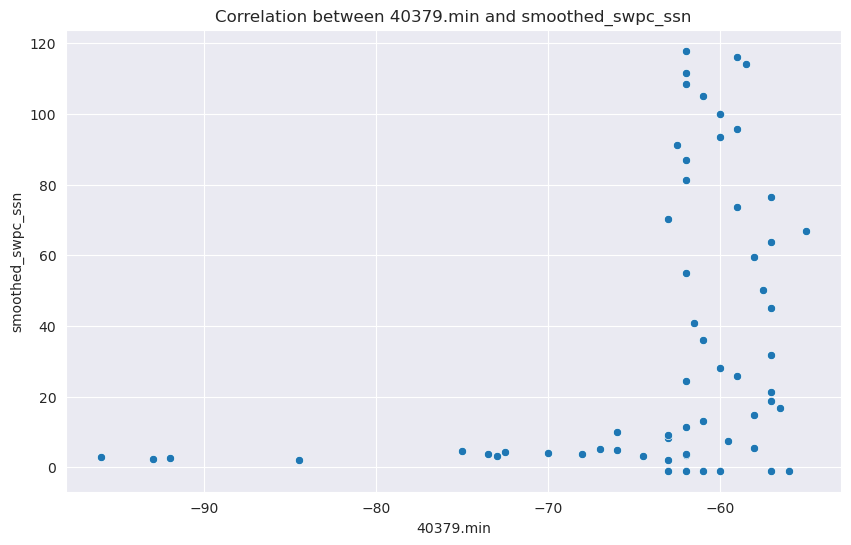

Analysis results:
Spearman's rank correlation: 0.3910217081843639
Kendall's tau: 0.2729327257339162
Correlation:  0.34818112178010135
                   40379.min  smoothed_swpc_ssn
40379.min           1.000000           0.348181
smoothed_swpc_ssn   0.348181           1.000000


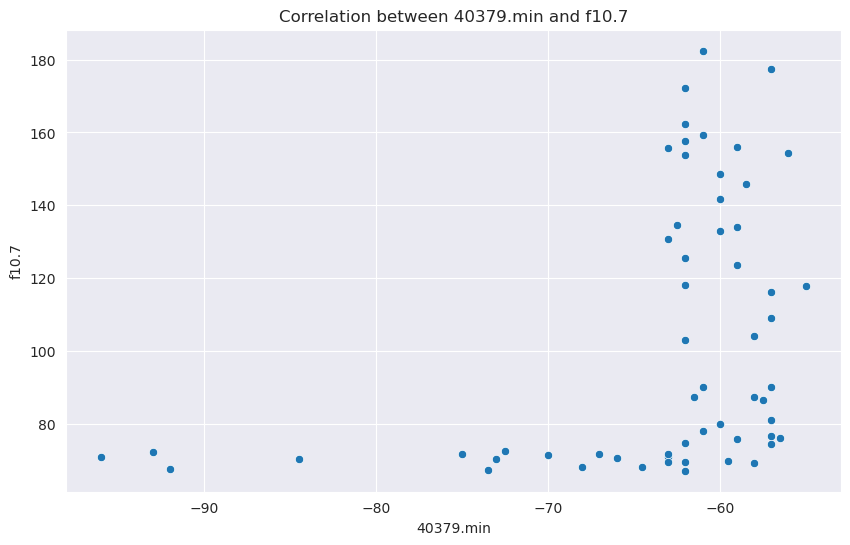

Analysis results:
Spearman's rank correlation: 0.46401701034542203
Kendall's tau: 0.2985161405395213
Correlation:  0.3631655974361399
           40379.min     f10.7
40379.min   1.000000  0.363166
f10.7       0.363166  1.000000


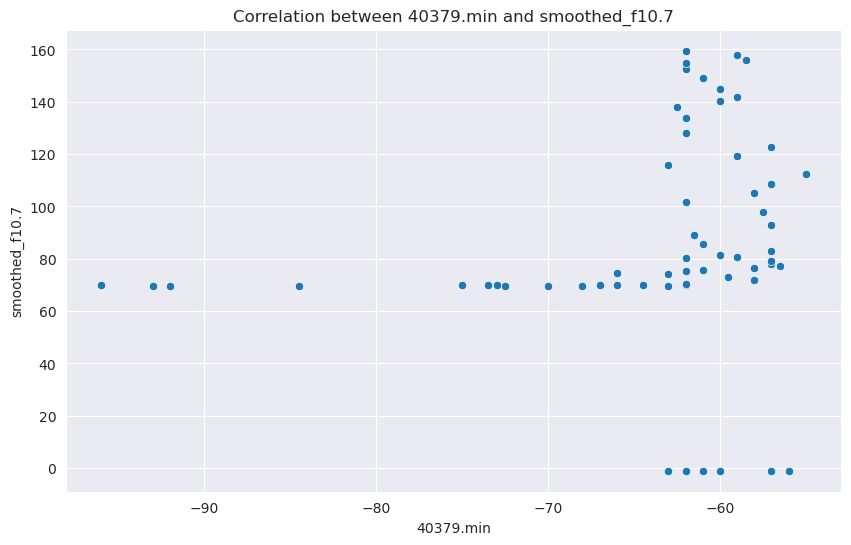

Analysis results:
Spearman's rank correlation: 0.39731540013551003
Kendall's tau: 0.2773974174937626
Correlation:  0.15774719814953828
                40379.min  smoothed_f10.7
40379.min        1.000000        0.157747
smoothed_f10.7   0.157747        1.000000


In [415]:
analyze_griffex('rssi.csv', '40379.min', 'ssn')
analyze_griffex('rssi.csv', '40379.min', 'smoothed_ssn')
analyze_griffex('rssi.csv', '40379.min', 'observed_swpc_ssn')
analyze_griffex('rssi.csv', '40379.min', 'smoothed_swpc_ssn')
analyze_griffex('rssi.csv', '40379.min', 'f10.7')
analyze_griffex('rssi.csv', '40379.min', 'smoothed_f10.7')